# Funnel Data Processing

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from fatiando import utils
from matplotlib import colors, ticker, cm
from IPython.display import Image as img

### Reading train data files

In [28]:
import glob
existing_file = glob.glob("*.csv")
existing_file

['funnel_data.csv']

In [29]:
os.remove(existing_file[0])

In [30]:
fnames = glob.glob("*.dat")
fnames

['Data_20190116_154029.dat',
 'Data_20190116_154200.dat',
 'Data_20190116_154258.dat',
 'Data_20190116_154401.dat',
 'Data_20190116_154452.dat',
 'Data_20190116_154548_28.dat',
 'Data_20190116_154649.dat',
 'Data_20190116_154747_24.dat',
 'Data_20190116_154850.dat',
 'Data_20190116_154943_20.dat',
 'Data_20190116_155039.dat',
 'Data_20190116_155133_16.dat',
 'Data_20190116_155226.dat',
 'Data_20190116_155312.dat',
 'Data_20190116_155406_10.dat',
 'Data_20190116_155452.dat',
 'Data_20190116_155539_6.dat',
 'Data_20190116_155627.dat',
 'Data_20190116_155709.dat',
 'Data_20190116_155758_0.dat']

In [31]:
for n, name in enumerate(fnames):

    print n, name
    data1 = pd.read_csv(name, skiprows=2, delim_whitespace=True, usecols=(3, 9, 10, 11), header=None, names=['V', 'Sx', 'Sy', 'Sz'], nrows=1022)

    data2 = pd.read_csv(name, skiprows=1024, delim_whitespace=True, usecols=(3, 5, 6, 7), header=None, names=['V', 'Sx', 'Sy', 'Sz'])

    data = pd.concat([data1, data2])

    volt = data['V'].get_values()
    train_dist = (volt - volt[0])*129.6/(volt[0] - volt[-1])
    print train_dist

    sy_dist = train_dist
    sz_dist = train_dist - 1.5
    sx_dist = train_dist - 3.

    maskz = (sz_dist <= 0.) & (sz_dist >= -133.6)

    dz = {'Sz': data['Sz'].get_values(), 'Sz_dist': sz_dist}
    dz = pd.DataFrame(data=dz)
    dz = dz[maskz].reset_index().drop(labels='index', axis=1)

    masky = (sy_dist >= -133.6)

    dy = {'Sy': data['Sy'].get_values(), 'Sy_dist': sy_dist}
    dy = pd.DataFrame(data=dy)
    dy = dy[masky].reset_index().drop(labels='index', axis=1)

    maskx = (sx_dist <= 0.) & (sx_dist >= -133.6)

    dx = {'Sx': data['Sx'][:], 'Sx_dist': sx_dist}
    dx = pd.DataFrame(data=dx)
    dx = dx[maskx].reset_index().drop(labels='index', axis=1)

    size = np.array([sx_dist[maskx].size, sy_dist[masky].size, sz_dist[maskz].size])

    lim = np.min(size)
    print lim

    df = {'Sx': dx['Sx'][:lim], 'Sy': dy['Sy'][:lim], 'Sz': dz['Sz'][:lim]}
    df = pd.DataFrame(data=df)

    dw = {'Line': np.ones(lim, dtype=np.int8) + n}
    dfw = pd.DataFrame(data=dw)
    dfw
    dfw.loc[:, 'X'] = n*2.
    dfw.loc[:, 'Y'] = dx['Sx_dist']
    dfw.loc[:, 'Bx'] = (df['Sy'] - df['Sx'])/np.sqrt(2.)
    dfw.loc[:, 'By'] = - df['Sz']
    dfw.loc[:, 'Bz'] = (df['Sy'] + df['Sx'])/np.sqrt(2.)
    dfw.loc[:, 'Bm'] = np.sqrt(dfw['Bx']**2. + dfw['By']**2. + dfw['Bz']**2.)

    if n == 0:
        header = True
    else:
        header = False
    dfw.to_csv('funnel_data.csv', index=None, sep=',', mode='a', header=header)

0 Data_20190116_154029.dat
[  0.00000000e+00  -3.03519989e-02  -3.94575985e-02 ...,  -1.29600000e+02
  -1.29606070e+02  -1.29600000e+02]
3000
1 Data_20190116_154200.dat
[  0.00000000e+00  -2.35572117e-02  -1.47232573e-02 ...,  -1.29611779e+02
  -1.29594111e+02  -1.29600000e+02]
3000
2 Data_20190116_154258.dat
[  0.00000000e+00  -2.91918191e-03  -5.83836382e-03 ...,  -1.29605838e+02
  -1.29597081e+02  -1.29600000e+02]
3000
3 Data_20190116_154401.dat
[  0.00000000e+00  -8.67547305e-03  -2.31345948e-02 ...,  -1.29602892e+02
  -1.29600000e+02  -1.29600000e+02]
3000
4 Data_20190116_154452.dat
[  0.00000000e+00   1.46865509e-02   3.23104120e-02 ...,  -1.29602937e+02
  -1.29597063e+02  -1.29600000e+02]
3000
5 Data_20190116_154548_28.dat
[  0.00000000e+00   5.87328922e-03   8.80993383e-03 ...,  -1.29576507e+02
  -1.29591190e+02  -1.29600000e+02]
3000
6 Data_20190116_154649.dat
[  0.00000000e+00  -5.84481476e-03  -5.84481476e-03 ...,  -1.29632146e+02
  -1.29623379e+02  -1.29600000e+02]
3000
7 D

In [32]:
dobs = pd.read_csv('funnel_data.csv')

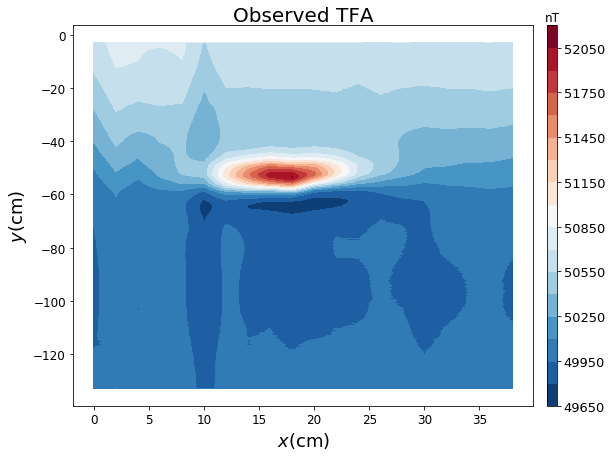

In [50]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(dobs['X'], dobs['Y'], dobs['Bm'], 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$x$(cm)', fontsize=18)
plt.ylabel('$y$(cm)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
#plt.savefig(mypath+'diorama_tfa_pred_data_true_inital.png', dpi=300)
plt.show()

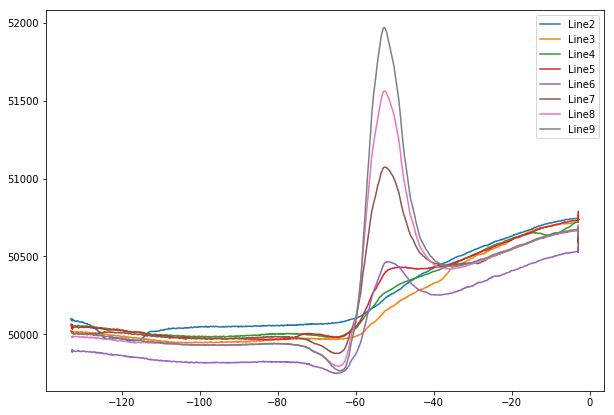

In [76]:
line = []
plt.figure(figsize=(10,7))
for i in range(2, 10, 1):
    mask = (dobs['Line'] == i)
    plt.plot(dobs[mask]['Y'], dobs[mask]['Bm'])
    line.append('Line'+str(i))
plt.legend(line)
plt.show()